## Initialization: Import devices, modules and start station

In [1]:
import sys
sys.path.append('C:/QCodes drivers and scripts/Drivers')

from PLH250P_current_source_dummy import TTi
from PLH250P_current_source_TCP import current_set,power_up as current_source_on,power_down as current_source_off
current_source = TTi('TTi')

import VNA_Anritsu as VNA_Anritsu
vna_gvf= VNA_Anritsu.MS46522B('VNA', 'TCPIP::192.168.0.52',  init_s_params=False)
vna_gvf.add_channel('S21')

from RS_SMB_100A import SMB100A
MW_source_1_gvf = SMB100A('SMB100A_1', 'TCPIP0::192.168.0.53::inst0::INSTR')
# MW_source_2_tvp = SMB100A('SMB100A_2', 'TCPIP0::192.168.0.54::inst0::INSTR')
# MW_source_3_gvf = SMB100A('SMB100A_3', 'TCPIP0::192.168.0.55::inst0::INSTR')

#Tunable Attenuator
from Vaunix_attn import Vaunix_attn
Vaunix_attn.connected_devices()
Vaunix_Att_1 = Vaunix_attn('Vaunix_Att_1', '23248')



# from RS_FSQ import RS_FSQ
# RS_SA_tvp = RS_FSQ('RS_FSQ', 'TCPIP0::192.168.0.61::inst0::INSTR')

from MW_switch_controller import set_rt_switch,set_cryo_switch

Connected to: Dummy corp current source 001 (serial:dummy 100, firmware:None) in 0.00s
Connected to: ANRITSU MS46522B (serial:1728106, firmware:V2019.12.1,V3.3.12) in 0.10s
Connected to: Rohde&Schwarz SMB100A (serial:1406.6000k03/177960, firmware:3.1.18.2-3.01.203.32) in 0.03s
1  attenuator(s) found with serial number(s):

    1.  23249
Connected to: Vaunix digital attenuator LDA-5018V (serial:23248, firmware:None) in 0.00s


In [2]:
import sys
import qcodes as qc
from qcodes.logger.logger import start_all_logging
import datetime
from qcodes.dataset.plotting import plot_dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
#qcodes.config.subscription.default_subscribers = ["Plottr"]
from time import sleep

from pprint import pprint
import json

sys.path.append('C:\QCodes drivers and scripts\Scripts\Arpit\Modules')
from notify import snotify
from progress_bar import bar


sys.path.append('C:\QCodes drivers and scripts\Scripts\Arpit\Modules')
from notify import snotify
from progress_barV2 import bar

import addcopyfighandler
from general_functions import find_nearest

In [3]:
start_all_logging()

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\nicolas.roch\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\nicolas.roch\.qcodes\logs\220302-4320-qcodes.log


In [4]:
#create a station
station = qc.Station()
station.add_component(vna_gvf)
station.add_component(current_source)
station.add_component(MW_source_1_gvf)
# station.add_component(MW_source_2_gvf)
# station.add_component(RS_SA_gvf)
station.snapshot()
station.components

{'VNA': <MS46522B: VNA>, 'TTi': <TTi: TTi>, 'SMB100A_1': <SMB100A: SMB100A_1>}

In [5]:
# Load experiment details
experiment_file = open('C:\QCodes drivers and scripts\Scripts\Arpit\_experiment_details.json','r')
experiment = experiment_file.readlines()
experiment=json.loads(''.join(experiment))

user = experiment['details']['user']
# date = experiment['details']['date']
date = '-'.join(str(datetime.date.today()).split('-'))
description = experiment['details']['description']
cooldown = experiment['details']['cooldown']
# database_name = date+"_"+'CD_'+cooldown+'_'+user+"_"+description
# print(database_name)
database_name = '2022-02-28_CD_22_02_TC_GC_GL_Tibo sample & RK TWPA'

#Create or Initialize the database
qc.initialise_or_create_database_at("D:/Data_QCodes/"+database_name)
qc.config.core.db_location

'D:/Data_QCodes/2022-02-28_CD_22_02_TC_GC_GL_Tibo sample & RK TWPA'

In [6]:
device_ids = experiment['device_ids']

## Sweep Pump pow and acquire Gain

In [21]:
parameter_snap={}

# VNA
start_freq = 3
end_freq = 13
points_per_gigahz = 100
VNA_power = -10
IF_bandwidth = 1000
Averages = 1
points_VNA=1+(end_freq-start_freq)*points_per_gigahz
points_VNA=int(points_VNA)
parameter_snap['vna']={'start_freq':start_freq,'end_freq':end_freq,'points_per_gigahz':points_per_gigahz,'VNA_power':VNA_power,'IF_bandwidth':IF_bandwidth,'Averages':Averages,'points':points_VNA}

parameter_snap['vna']={'start_freq':start_freq,'end_freq':end_freq,'points_per_gigahz':points_per_gigahz,'IF_bandwidth':IF_bandwidth,'Averages':Averages,'points':points_VNA}


# MW Source Pump
pump_frequency= 8.1
# pump_power=-7#22#13.7

pump_power_start = -5
pump_power_end = 12
pump_power_step = 0.1
points_pump_power = 1+(pump_power_end-pump_power_start)/pump_power_step
# points_pump_power = 101#int(points_pump_power)

parameter_snap['pump']={'pump_frequency':pump_frequency,'pump_power_start':pump_power_start,'pump_power_end':pump_power_end,'pump_power_step':pump_power_step,'points_pump_power':points_pump_power}


MW_source_1_gvf.frequency(pump_frequency*1e9)
MW_source_1_gvf.power(pump_power_start)
MW_source_1_gvf.phase(0)


# Current source
I = -3.5
parameter_snap['flux']={'I':I}
current_set(I)



vna_gvf.channels.S21.bandwidth(IF_bandwidth)
vna_gvf.channels.S21.power(VNA_power)
vna_gvf.channels.S21.avg(Averages)
vna_gvf.channels.npts(points_VNA)
vna_gvf.channels.start(start_freq*1e9)
vna_gvf.channels.stop(end_freq*1e9)



# Initialize devices
vna_gvf.rf_on()
vna_gvf.cont_meas_on()
current_source_on()
# MW_source_2_gvf.status('off')
# set_rt_switch('NC')

experiment_file = open('C:\QCodes drivers and scripts\Scripts\Arpit\_experiment_details.json','r')
experiment = experiment_file.readlines()
experiment = json.loads(''.join(experiment))
switch_position = experiment['current_device']['current_device']

for pump in ['off','on']:
    exp_name = 'Gain vs pump power : pump '+pump
    sample_name = device_ids[switch_position]
#     sample_name = '(RK)TWPA V08 00 (0,2) paper'#'T3PA V08.02 32 250cells'
#     sample_name = 'JPA graphene'#'T3PA V08.02 32 250cells'

    exp=qc.load_or_create_experiment(experiment_name=exp_name,
                              sample_name=sample_name)
    
    meas = qc.Measurement(exp=exp, station=station) 
    meas.register_parameter(MW_source_1_gvf.power) 
    meas.register_parameter(vna_gvf.channels.S21.trace_mag_phase, setpoints=(MW_source_1_gvf.power,)) 
    meas.write_period = 2

    with meas.run() as datasaver:
        MW_source_1_gvf.status(pump)
#         MW_source_3_gvf.status(pump)
        for pump_power in bar(np.linspace(pump_power_start, pump_power_end, points_pump_power)):
            pump_power=round(pump_power,2)
            MW_source_1_gvf.power(pump_power)
            get_v = vna_gvf.channels.S21.trace_mag_phase.get()
            datasaver.add_result((MW_source_1_gvf.power, pump_power),
                                 (vna_gvf.channels.S21.trace_mag_phase, get_v))
    id_num=datasaver.dataset.run_id
    qc.load_by_run_spec( captured_run_id=id_num).add_metadata('parameter_snap',json.dumps(parameter_snap))
            

            
# Shutdown devices
vna_gvf.rf_off()
vna_gvf.cont_meas_off()
# current_source_off()
MW_source_1_gvf.status('off')
#MW_source_3_gvf.status('off')
# snotify('arpit.ranadive@gmail.com','Finished: '+exp_name+' '+sample_name)

Starting experimental run with id: 12. 


Starting experimental run with id: 13. 


## Plot gain vs pump pow

In [7]:
captured_run_id_off = 2

captured_run_id_on = 3
dataset_on = qc.load_by_run_spec(captured_run_id=captured_run_id_on)
dataset_off = qc.load_by_run_spec( captured_run_id=captured_run_id_off)
# json.loads(dataset_on.get_metadata('parameter_snap'))

print(dataset_on)
print()


metadata = dataset_off.get_metadata('parameter_snap')
print(metadata)
points_VNA = metadata[metadata.find('"points"')+10:metadata.find("pump")-4]
print(points_VNA)

results #3@D:\Data_QCodes\2022-02-28_CD_22_02_TC_GC_GL_Tibo sample & RK TWPA
----------------------------------------------------------------------------
SMB100A_1_power - numeric
VNA_S21_S21_frequency - numeric
magnitude - numeric
phase - numeric

{"vna": {"start_freq": 3, "end_freq": 13, "points_per_gigahz": 100, "IF_bandwidth": 1000, "Averages": 1, "points": 1001}, "pump": {"pump_frequency": 8.1, "pump_power_start": -5, "pump_power_end": 12, "pump_power_step": 0.1, "points_pump_power": 171.0}, "flux": {"I": 0.3}}
1001


In [8]:
pump_pow_data=list(dict.fromkeys(dataset_on.get_parameter_data('SMB100A_1_power')['SMB100A_1_power']['SMB100A_1_power']))

#print(pump_pow_data)

points_VNA=int(metadata[metadata.find('"points"')+10:metadata.find("pump")-4])

freq_data=dataset_on.get_parameter_data('magnitude')['magnitude']['VNA_S21_S21_frequency'][0:points_VNA]*1e-9
magnitude_on=(dataset_on.get_parameter_data('magnitude')['magnitude']['magnitude']).reshape(len(pump_pow_data),len(freq_data))
magnitude_off=(dataset_off.get_parameter_data('magnitude')['magnitude']['magnitude']).reshape(len(pump_pow_data),len(freq_data))

In [9]:
# sample_name = '(RK)TWPA V08 00 (3,2) '

<IPython.core.display.Javascript object>


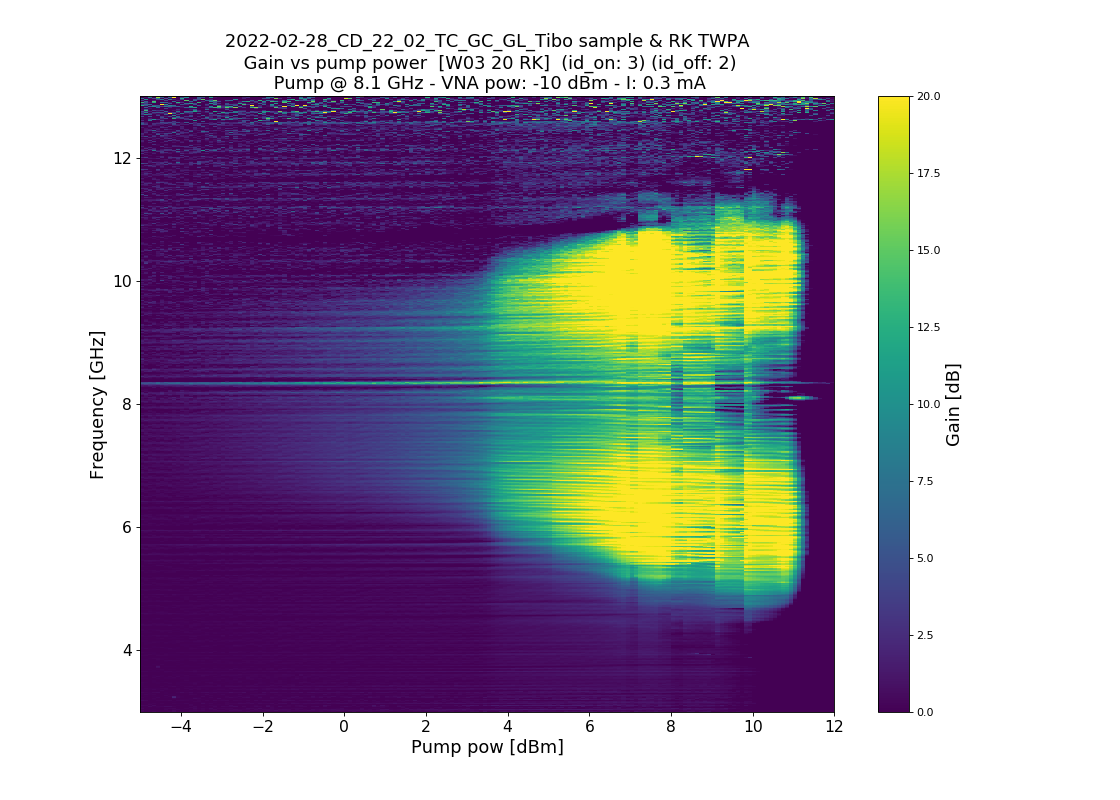

In [11]:
plt.figure(figsize=(14, 10), dpi= 80) #facecolor='w', edgecolor='k'

# plot_title=database_name+'\n'+exp_name.split(':')[0]+'  ['+sample_name+']  (id_on: '+str(captured_run_id_on)+') (id_off: '+str(captured_run_id_off)+')'
# plot_title+='\n Pump @ '+str(pump_frequency)+' GHz    '+ 'VNA pow: '+str(VNA_power)+' dBm'+'    I = '+str(I)+' mA'

plot_title=database_name+'\n Gain vs pump power  [W03 20 RK]  (id_on: '+str(captured_run_id_on)+') (id_off: '+str(captured_run_id_off)+')'
plot_title+='\n Pump @ 8.1 GHz - VNA pow: -10 dBm - I: 0.3 mA'


X, Y = np.meshgrid(np.array(pump_pow_data),np.array(freq_data))
Z = (magnitude_on-magnitude_off).T
# plt.pcolor(X, Y, Z)
plt.pcolor(X, Y, Z, vmin=0, vmax=20)
cbar=plt.colorbar()
cbar.set_label('Gain [dB]', size=16)

# plt.plot(pump_pow_data,np.ones(len(pump_pow_data))*pump_frequency, color = 'r', linestyle = '--', label = 'pump')
# plt.plot(pump_pow_data,np.ones(len(pump_pow_data))*pump_frequency*0.5, color = 'r', linestyle = '--', label = 'pump/2')
# plt.plot(pump_pow_data,np.ones(len(pump_pow_data))*pump_frequency*2, color = 'r', linestyle = '--', label = '2*pump')

plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.xticks(fontsize=14)    # fontsize of the tick labels
plt.yticks(fontsize=14) 

x_label='Pump pow [dBm]'
y_label='Frequency [GHz]'
plt.xlabel(x_label, size=16)
plt.ylabel(y_label, size=16)
# plt.ylim(3, 10)
plt.title(plot_title, size=16)

plt.show()

### Plot vertical cut

<IPython.core.display.Javascript object>


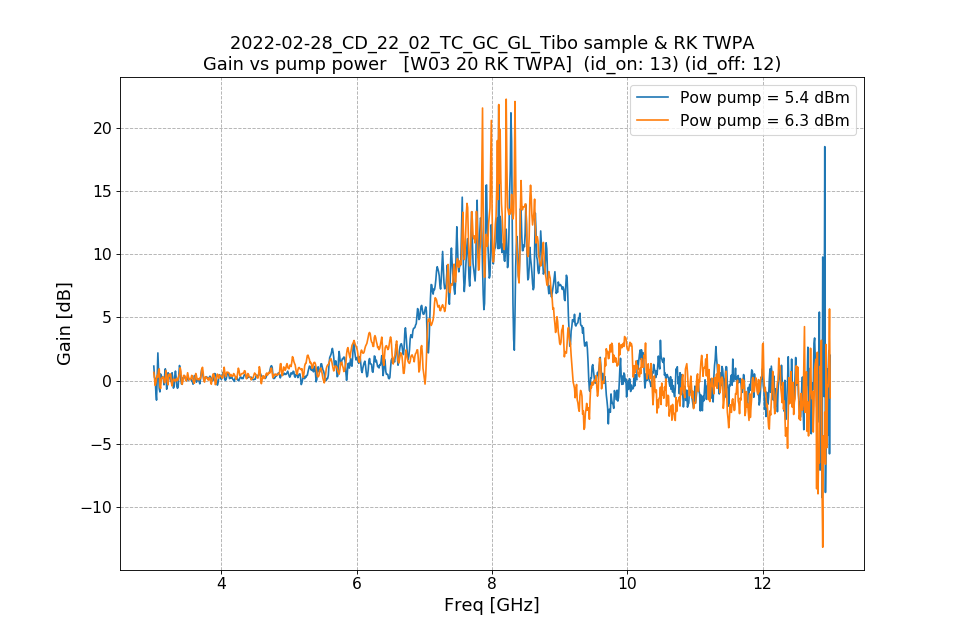

In [26]:
# power_list=1*np.array([6.3, 6.8, 7.6])
power_list=1*np.array([6.3])

# plot_title=database_name+'\n'+exp_name.split(':')[0]+'  ['+sample_name+']  (id_on: '+str(captured_run_id_on)+') (id_off: '+str(captured_run_id_off)+')'
plot_title=database_name+'\n Gain vs pump power  [W03 20 RK]  (id_on: '+str(captured_run_id_on)+') (id_off: '+str(captured_run_id_off)+')'
plot_title+='\n Pump @ 8.1 GHz - VNA pow: -10 dBm - I: 0.3 mA'

gain=magnitude_on-magnitude_off

plt.figure(figsize=(12, 8), dpi= 80) #facecolor='w', edgecolor='k'
x_label='Freq [GHz]'
y_label='Gain [dB]'

plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('grid', linestyle="--")
plt.grid(True)

for power in power_list:
    plt.plot(freq_data,gain[find_nearest(pump_pow_data,power)],label='Pow pump = '+str(power)+' dBm')#marker="."
    
plt.xlabel(x_label, size=16)
plt.ylabel(y_label, size=16)
plt.title(plot_title, size=16)

# delta = 0
# plt.axvline(pump_frequency-delta)
# plt.axvline(pump_frequency+delta)
# plt.axvline(pump_frequency+0.05)
# plt.axvline(pump_frequency-0.05)

plt.legend(fontsize = 14)
# plt.xlim(3, 12)
# plt.ylim(10, 25)
plt.show()    

## Plot Horizontal cut

<IPython.core.display.Javascript object>


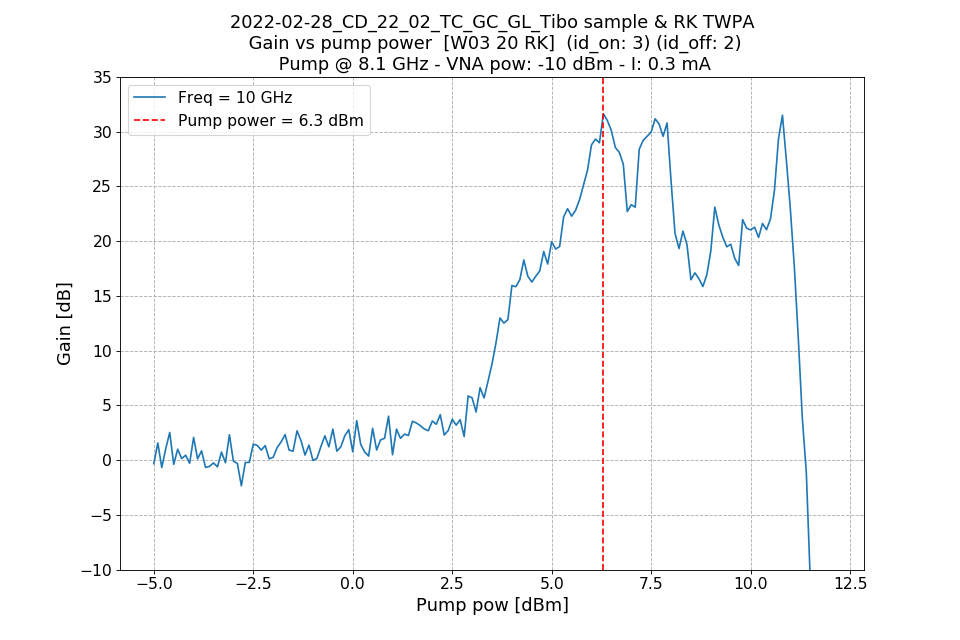

In [16]:
# delta = 0.001
# frq_list=1*np.array([pump_frequency-delta,pump_frequency+delta])
frq_list = [10]
pump_pow_list = [6.3]

#print(freq_data)

# plot_title=database_name+'\n'+exp_name.split(':')[0]+'  ['+sample_name+']  (id_on: '+str(captured_run_id_on)+') (id_off: '+str(captured_run_id_off)+')'
# plot_title+='\n Pump @ '+str(pump_frequency)+' GHz    Freq: '+str(start_freq)+' to '+str(end_freq)+';'+str(points_per_gigahz)+'    VNA pow: '+str(VNA_power)+' dBm'

plot_title=database_name+'\n Gain vs pump power  [W03 20 RK]  (id_on: '+str(captured_run_id_on)+') (id_off: '+str(captured_run_id_off)+')'
plot_title+='\n Pump @ 8.1 GHz - VNA pow: -10 dBm - I: 0.3 mA'

gain=(magnitude_on-magnitude_off).T

plt.figure(figsize=(12, 8), dpi= 80) #facecolor='w', edgecolor='k'
x_label='Pump pow [dBm]'
y_label='Gain [dB]'

plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('grid', linestyle="--")
plt.grid(True)

for freq in frq_list:
    plt.plot(pump_pow_data,gain[find_nearest(freq_data,freq)],label='Freq = '+str(round(freq, 5))+' GHz')#marker="."
    
plt.axvline(pump_pow_list[0], color = 'r', linestyle = '--', label = 'Pump power = '+ str(pump_pow_list[0])+' dBm')
# plt.axvline(pump_pow_list[1], color = 'k', linestyle = '--', label = 'Pump power = '+ str(pump_pow_list[1])+' dBm')
# plt.axvline(pump_pow_list[2], color = 'b', linestyle = '--', label = 'Pump power = '+ str(pump_pow_list[2])+' dBm')
# plt.axvline(pump_pow_list[3], color = 'g', linestyle = '--', label = 'Pump power = '+ str(pump_pow_list[3])+' dBm')

plt.xlabel(x_label, size=16)
plt.ylabel(y_label, size=16)
plt.title(plot_title, size=16)

plt.legend(fontsize = 14, loc = 'upper left')
plt.ylim(-10, 35)
# plt.xlim(-5, 8)
plt.show()    

## Sweep Tunable Attenuator and acquire Gain with VNA

In [140]:
attn = 8
Vaunix_Att_1.attn((attn))

In [148]:
parameter_snap={}

# VNA
start_freq=1.5
end_freq=7.5
points_per_gigahz=20
VNA_power = -20
IF_bandwidth=1000
Averages=1
points_VNA=1+(end_freq-start_freq)*points_per_gigahz
points_VNA=int(points_VNA)
parameter_snap['vna']={'start_freq':start_freq,'end_freq':end_freq,'points_per_gigahz':points_per_gigahz,'VNA_power':VNA_power,'IF_bandwidth':IF_bandwidth,'Averages':Averages,'points':points_VNA}

parameter_snap['vna']={'start_freq':start_freq,'end_freq':end_freq,'points_per_gigahz':points_per_gigahz,'IF_bandwidth':IF_bandwidth,'Averages':Averages,'points':points_VNA}


# MW Source Pump
pump_frequency=4.000002 - 0.020
pump_power=25
MW_source_3_gvf.frequency(pump_frequency*1e9)
MW_source_3_gvf.power(pump_power)
MW_source_3_gvf.phase(0)


# MW_source_1_gvf.frequency(pump_frequency*1e9)
# MW_source_1_gvf.power(pump_power)
# MW_source_1_gvf.phase(0)


parameter_snap['pump']={'pump_frequency':pump_frequency,'pump_power':pump_power}


### Attenuation
attn_start = 18
attn_end = 4
attn_step = 0.2
points_attn=1+abs(attn_end-attn_start)/attn_step
points_attn=int(points_attn)
attn_data = np.linspace(attn_start, attn_end, points_attn)

parameter_snap['attnn']={'attn_start':attn_start,'attn_end':attn_end,'attn_step':attn_step,'points_attn':points_attn}

# Current source
I = 0.2
parameter_snap['flux']={'I':I}
current_set(I)

vna_gvf.channels.S21.bandwidth(IF_bandwidth)
vna_gvf.channels.S21.power(VNA_power)
vna_gvf.channels.S21.avg(Averages)
vna_gvf.channels.npts(points_VNA)
vna_gvf.channels.start(start_freq*1e9)
vna_gvf.channels.stop(end_freq*1e9)


# Initialize devices
vna_gvf.rf_on()
vna_gvf.cont_meas_on()
current_source_on()
#MW_source_2_gvf.status('off')
set_rt_switch('NC')


for pump in ['off','on']:
    exp_name = 'Gain vs att : pump '+pump
    sample_name = 'T3PA V08 02'
    exp=qc.load_or_create_experiment(experiment_name=exp_name,
                              sample_name=sample_name)
    
    meas = qc.Measurement(exp=exp, station=station) 
    meas.register_parameter(Vaunix_Att_1.attn) 
    meas.register_parameter(vna_gvf.channels.S21.trace_mag_phase, setpoints=(Vaunix_Att_1.attn,)) 
    meas.write_period = 2

    with meas.run() as datasaver:
        MW_source_3_gvf.status(pump)
        #MW_source_1_gvf.status(pump)
        for attn in bar(attn_data):
            attn=round(attn,2)
            Vaunix_Att_1.attn((attn))
            get_v = vna_gvf.channels.S21.trace_mag_phase.get()
            datasaver.add_result((Vaunix_Att_1.attn, attn),
                                 (vna_gvf.channels.S21.trace_mag_phase, get_v))
    id=datasaver.dataset.run_id
    qc.load_by_run_spec( captured_run_id=id).add_metadata('parameter_snap',json.dumps(parameter_snap))
            

            
# Shutdown devices
vna_gvf.rf_off()
vna_gvf.cont_meas_off()
current_source_off()
MW_source_3_gvf.status('off')
#MW_source_1_gvf.status('off')
# snotify('arpit.ranadive@gmail.com','Finished: '+exp_name+' '+sample_name)

### Warning: Power over range (limit to 16 dBm).
Starting experimental run with id: 61. 


Starting experimental run with id: 62. 


## Plot gain vs pump att

In [149]:
captured_run_id_off=61#31#29

captured_run_id_on=captured_run_id_off+1
dataset_on = qc.load_by_run_spec(captured_run_id=captured_run_id_on)
dataset_off = qc.load_by_run_spec( captured_run_id=captured_run_id_off)
# json.loads(dataset_on.get_metadata('parameter_snap'))

print(dataset_on)
print()


metadata = dataset_off.get_metadata('parameter_snap')
print(metadata)
points_VNA = metadata[metadata.find('"points"')+10:metadata.find("pump")-4]
print(points_VNA)

results #62@C:\Data_QCodes\2020-07-28_AR_ME_2_devices_T3PA_V08_with_noise_source_run3
-------------------------------------------------------------------------------------
Vaunix_Att_1_attn - numeric
VNA_S21_S21_frequency - numeric
magnitude - numeric
phase - numeric

{"vna": {"start_freq": 1.5, "end_freq": 7.5, "points_per_gigahz": 20, "IF_bandwidth": 1000, "Averages": 1, "points": 121}, "pump": {"pump_frequency": 3.9800020000000003, "pump_power": 25}, "attnn": {"attn_start": 18, "attn_end": 4, "attn_step": 0.2, "points_attn": 71}, "flux": {"I": 0.2}}
121


In [150]:
attn_data=list(dict.fromkeys(dataset_on.get_parameter_data('Vaunix_Att_1_attn')['Vaunix_Att_1_attn']['Vaunix_Att_1_attn']))

#print(attn_data)

points_VNA=int(metadata[metadata.find('"points"')+10:metadata.find("pump")-4])

freq_data=dataset_on.get_parameter_data('magnitude')['magnitude']['VNA_S21_S21_frequency'][0:points_VNA]*1e-9
magnitude_on=(dataset_on.get_parameter_data('magnitude')['magnitude']['magnitude']).reshape(len(attn_data),len(freq_data))
magnitude_off=(dataset_off.get_parameter_data('magnitude')['magnitude']['magnitude']).reshape(len(attn_data),len(freq_data))

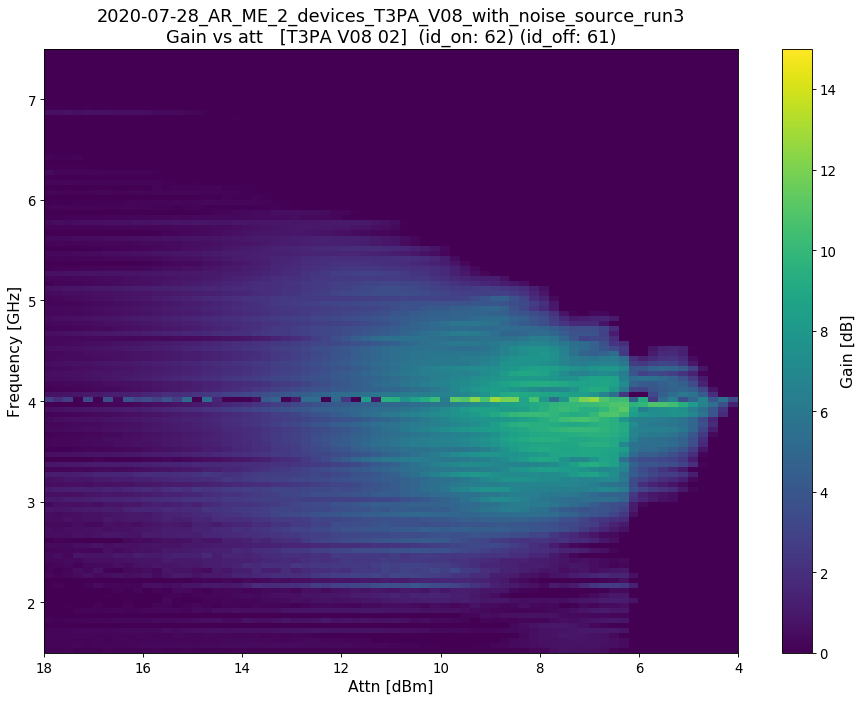

In [151]:
plt.figure(figsize=(14, 10), dpi= 80) #facecolor='w', edgecolor='k'

plot_title=database_name+'\n'+exp_name.split(':')[0]+'  ['+sample_name+']  (id_on: '+str(captured_run_id_on)+') (id_off: '+str(captured_run_id_off)+')'

X, Y = np.meshgrid(np.array(attn_data),np.array(freq_data))
Z = (magnitude_on-magnitude_off).T
# plt.pcolor(X, Y, Z)
plt.pcolor(X, Y, Z, vmin=0, vmax=15)
cbar=plt.colorbar()
cbar.set_label('Gain [dB]', size=14)

plt.rc('axes', labelsize=12)    # fontsize of the x and y labels

x_label='Attn [dBm]'
y_label='Frequency [GHz]'
plt.xlabel(x_label, size=14)
plt.ylabel(y_label, size=14)
plt.title(plot_title, size=16)
plt.xlim(18, 4)

plt.show()

### Plot vertical cut

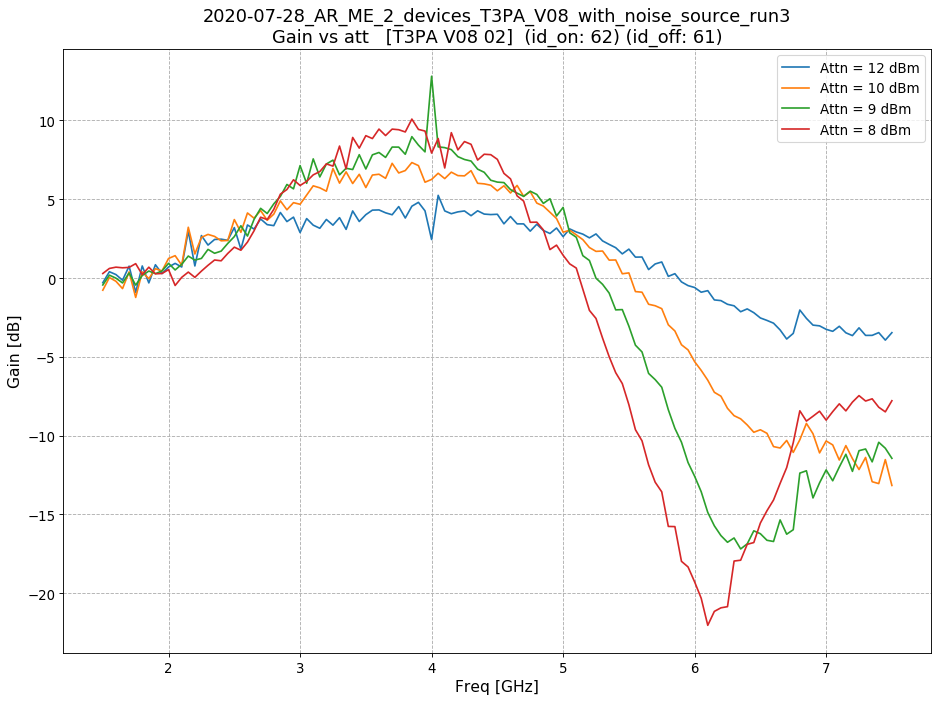

In [153]:
power_list=1*np.array([12, 10,9,8])

#plot_title=database_name+'\n'+exp_name.split(':')[0]+'  ['+sample_name+']  (id_on: '+str(captured_run_id_on)+') (id_off: '+str(captured_run_id_off)+')'
#plot_title+='\n Pump '+str(attner)+' dBm @ '+str(pump_frequency)+' GHz    Freq: '+str(start_freq)+' to '+str(end_freq)+';'+str(points_per_gigahz)

gain=magnitude_on-magnitude_off

plt.figure(figsize=(14, 10), dpi= 80) #facecolor='w', edgecolor='k'
x_label='Freq [GHz]'
y_label='Gain [dB]'

plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('grid', linestyle="--")
plt.grid(True)

for power in power_list:
    plt.plot(freq_data,gain[attn_data.index(power)],label='Attn = '+str(power)+' dBm')#marker="."
    
plt.xlabel(x_label, size=14)
plt.ylabel(y_label, size=14)
plt.title(plot_title, size=16)

plt.legend(fontsize = 12)
#plt.xlim(3, 12)
#plt.ylim(-6, 30)
plt.show()    

### Horizontal plot

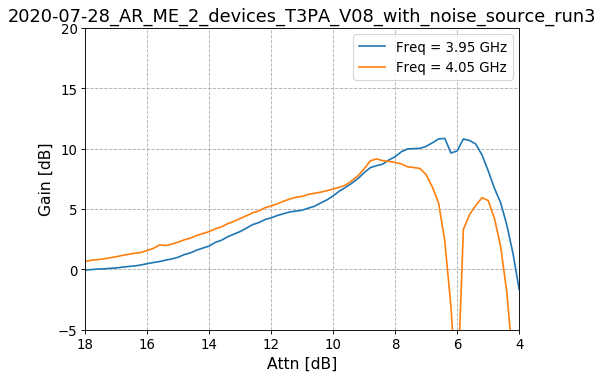

In [155]:
frq_list=1*np.array([3.95,  4.05])

#print(freq_data)

#plot_title=database_name+'\n'+exp_name.split(':')[0]+'  ['+sample_name+']  (id_on: '+str(captured_run_id_on)+') (id_off: '+str(captured_run_id_off)+')'
#plot_title+='\n Pump '+str(attner)+' dBm @ '+str(pump_frequency)+' GHz    Freq: '+str(start_freq)+' to '+str(end_freq)+';'+str(points_per_gigahz)

plot_title=database_name

gain=(magnitude_on-magnitude_off).T

plt.figure(figsize=(7, 5), dpi= 80) #facecolor='w', edgecolor='k'
x_label='Attn [dB]'
y_label='Gain [dB]'

plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('grid', linestyle="--")
plt.grid(True)

for freq in frq_list:
    plt.plot(attn_data,gain[list(freq_data).index(freq)],label='Freq = '+str(freq)+' GHz')#marker="."
    
plt.xlabel(x_label, size=14)
plt.ylabel(y_label, size=14)
plt.title(plot_title, size=16)

plt.legend(fontsize = 12)
plt.xlim(18, 4)
plt.ylim(-5, 20)
#plt.xlim(-1, 26)
plt.show()    